# Sentiment Analysis on Google Play store apps

<h2> Import Data 

In [1]:
import pandas as pd
import numpy as np

import re
import os
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
reviews = pd.read_csv('googleplaystore_user_reviews.csv')
reviews = reviews.dropna()
reviews.head(10)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000
6,10 Best Foods for You,Amazing,Positive,0.60,0.900000
8,10 Best Foods for You,"Looking forward app,",Neutral,0.00,0.000000
9,10 Best Foods for You,It helpful site ! It help foods get !,Neutral,0.00,0.000000
10,10 Best Foods for You,good you.,Positive,0.70,0.600000
11,10 Best Foods for You,Useful information The amount spelling errors ...,Positive,0.20,0.100000


<h2> Data cleaning & wrangling

In [3]:
# encode sentiment into numeric values
conditions = [
    (reviews['Sentiment'] == 'Positive'),
    (reviews['Sentiment'] == 'Neutral'),
    (reviews['Sentiment'] == 'Negative')]

choices = [1, 0, -1]
reviews['Sentiment_encode'] = np.select(conditions, choices, default= None)

In [4]:
# take a look at the sentiment distribution
reviews.Sentiment_encode.value_counts() 

 1    23998
-1     8271
 0     5158
Name: Sentiment_encode, dtype: int64

In [5]:
# clean text data
def clean_text(sentence):
    sent = sentence.lower()  # lowercase
    sent = re.sub(r'[^\w\s]',' ',sent) # remove punctuation
    sent = sent.replace(os.linesep,"")  # remove line break
    sent = re.sub(r'\d+','',sent)  # remove digits
#     sent = ' '.join([tok for tok in sent.split() if tok not in STOP_WORDS]) # remove stopwords vs. with stopwords
    return sent

In [6]:
reviews['reviews'] = reviews['Translated_Review'].apply(clean_text)
reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_encode,reviews
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,1,i like eat delicious food that s i m cooking ...
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,1,this help eating healthy exercise regular basis
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,1,works great especially going grocery store
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,1,best idea us
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,1,best way


In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(reviews['reviews'],reviews['Sentiment_encode'],test_size = 0.3, random_state=0)
X_train.head()

8671     been using paid version years now  originally ...
29070    i love app  using ages  however latest ver   s...
58115    i hate  weeks waiting items i find not getting...
12111                                             the best
2609     new tos data collection   i m out     uninstal...
Name: reviews, dtype: object

In [8]:
train, test = train_test_split(reviews,test_size = 0.3, random_state=0)
train.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_encode,reviews
8671,Apex Launcher,Been using paid version years now. Originally ...,Positive,0.340000,0.680000,1,been using paid version years now originally ...
29070,ConvertPad - Unit Converter,"I love app, using ages, however latest ver 3.1...",Positive,0.425000,0.550000,1,i love app using ages however latest ver s...
58115,H&M,I hate 2 weeks waiting items I find NOT gettin...,Negative,-0.900000,0.950000,-1,i hate weeks waiting items i find not getting...
12111,Bagan - Myanmar Keyboard,The best,Positive,1.000000,0.300000,1,the best
2609,AC - Tips & News for Android™,New TOS data collection.. I'm out!!! (Uninstal...,Positive,0.266335,0.454545,1,new tos data collection i m out uninstal...


<h2>logistic regression

In [9]:
# logistic regression
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

text_clf_LR = Pipeline([('vect', CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression())])

text_clf_LR.fit(train.reviews.values, train.Sentiment_encode.astype('int')) 
predicted_LR = text_clf_LR.predict(test.reviews.values)

print('predicted values:',predicted_LR)
accuracy_score(predicted_LR, test.Sentiment_encode.astype('int'))   # logistic regression 有0.87 accuracy
# accuracy_score(predicted_LR, X_test.values)

predicted values: [-1  0 -1 ...  1 -1  1]


0.8831596758393445

<h3>N-gram with logistic regression：（-> unigram with stopwords效果最好）

In [10]:
# testing
CountVectorizer().get_params().keys() # check the available params of CountVectorizer()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'preprocessor', 'stop_words', 'strip_accents', 'token_pattern', 'tokenizer', 'vocabulary'])

In [11]:
# compare accuracy of unigram, bigram, trigram

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)  # 这里我只取了10000作为max_features

# cvec.set_params(stop_words = STOP_WORDS, max_features=10000, ngram_range=(1,1))    # unigram without stopwords: 0.8721
# cvec.set_params(max_features=10000, ngram_range=(1,2))  # bigram without stopwords: 0.87024
# cvec.set_params(max_features=10000, ngram_range=(1,3))  # trigram without stopwords: 0.8705

text_clf_LR = Pipeline([('vect', cvec),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LogisticRegression())])

text_clf_LR.fit(train.reviews.values, train.Sentiment_encode.astype('int')) 
predicted_LR = text_clf_LR.predict(test.reviews.values)
print('predicted values:',predicted_LR)
accuracy_score(predicted_LR, test.Sentiment_encode.astype('int'))   

predicted values: [-1  0 -1 ...  1 -1  1]


0.8859203847181405

In [12]:
# check the number of features of Count vectorizer
len(cvec.get_feature_names())   # 总共有17616个features在count vectorizer

17616

CountVectorizer()的params: 排除了stopwords之后，unigram的表现最好，好于bigram和trigram
- 有stopwords跟排除stopwords结果差不多；
- max_features增加，accuracy反而下降

In [13]:
# TODO： plot出unigram, bigram, trigram比较图(iterate over num. of features)
# 参考：https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-4-count-vectorizer-b3f4944e51b5

<h3>TfidfVectorizer() vs. CountVectorizer() (-> 没有显著差别）

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
TfidfVectorizer().get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer()
lr = LogisticRegression()

tvec.set_params(stop_words = STOP_WORDS, max_features=10000, ngram_range=(1,1))  # unigram  -> o.8721
# tvec.set_params(stop_words = STOP_WORDS, max_features=10000, ngram_range=(1,2))  # bigram  -> 0.87024

text_clf_LR_tfidf = Pipeline([('vect', tvec),
                         ('clf', LogisticRegression())])

text_clf_LR_tfidf.fit(train.reviews.values, train.Sentiment_encode.astype('int')) 
predicted_LR = text_clf_LR_tfidf.predict(test.reviews.values)
print('predicted values:',predicted_LR)
accuracy_score(predicted_LR, test.Sentiment_encode.astype('int'))

predicted values: [ 0 -1 -1 ...  1 -1  1]


0.8721168403241607

之前用CountVectorizer()是pipeline包含了tf-idf transformer的，所以performance跟使用tdidfVectorizer()效果一样

In [15]:
# check the number of features of tfidf vectorizer
len(tvec.get_feature_names())

10000

这个tfidf vectorizer一共有10000 features (之前设param时定义10000 作为 max_feature value）

In [16]:
%%time
print("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))  # trigram

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)



NameError: name 'nfeature_accuracy_checker' is not defined

<h3> Other Classifier

In [17]:
# linear SVC
from sklearn.svm import LinearSVC

tvec = TfidfVectorizer()
svc = LinearSVC()

# tvec.set_params(stop_words = STOP_WORDS, max_features=10000, ngram_range=(1,1))  # unigram -> 0.893
tvec.set_params(max_features=10000, ngram_range=(1,3))  # trigram -> 0.8941 accuracy

text_clf_svc_tfidf = Pipeline([('vect', tvec),
                         ('clf', LinearSVC())])

text_clf_svc_tfidf.fit(train.reviews.values, train.Sentiment_encode.astype('int')) 
predicted_svc = text_clf_svc_tfidf.predict(test.reviews.values)
print('predicted values:',predicted_svc)
accuracy_score(predicted_svc, test.Sentiment_encode.astype('int'))   

predicted values: [ 0 -1 -1 ...  1 -1  1]


0.9244812538961618

In [18]:
# RidgeClassifier()
from sklearn.linear_model import RidgeClassifier

tvec = TfidfVectorizer()
rc = RidgeClassifier()

# tvec.set_params(stop_words = STOP_WORDS, max_features=10000, ngram_range=(1,1))   # unigram: 0.844
tvec.set_params(max_features=10000, ngram_range=(1,2)) # bigram: 0.856

text_clf_rc_tfidf = Pipeline([('vect', tvec),
                         ('clf', RidgeClassifier())])

text_clf_rc_tfidf.fit(train.reviews.values, train.Sentiment_encode.astype('int')) 
predicted_rc = text_clf_rc_tfidf.predict(test.reviews.values)
print('predicted values:',predicted_rc)
accuracy_score(predicted_rc, test.Sentiment_encode.astype('int'))  

predicted values: [ 0  1 -1 ...  1  1  1]


0.8773710927063852

In [19]:
# PassiveAggressiveClassifier()

from sklearn.linear_model import PassiveAggressiveClassifier

tvec = TfidfVectorizer()
pac = PassiveAggressiveClassifier()

# tvec.set_params(stop_words = STOP_WORDS, max_features=10000, ngram_range=(1,1))  # unigram: 0.893
tvec.set_params(max_features=10000, ngram_range=(1,2))    # bigram: 0.895 (max)

text_clf_pac_tfidf = Pipeline([('vect', tvec),
                         ('clf', PassiveAggressiveClassifier())])

text_clf_pac_tfidf.fit(train.reviews.values, train.Sentiment_encode.astype('int')) 
predicted_pac = text_clf_pac_tfidf.predict(test.reviews.values)
print('predicted values:',predicted_pac)
accuracy_score(predicted_pac, test.Sentiment_encode.astype('int'))  

predicted values: [ 0 -1 -1 ...  1 -1  1]


0.9279544037759373

<h4>结果:</h4> 
linear_SVC(trigram:0.894) | PassiveAggressiveClassifier(bigram:0.895) | Logistic_regression (unigram: 0.87021) | Ridge Classifier (bigram: 0.856) 

<h3> Ensemble classifier

结合上面几个performance比较好的classifier,去建一个ensemble classifier。再看performance是否变好

In [20]:
# 此function用于比较pipeline classifier, 基于accuracy和training time (TODO：内部结构待弄懂)

from time import time

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time



In [21]:
# compare the accuracy and training time for each classifier

from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Ridge Classifier", "Passive-Aggresive"]

classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    RidgeClassifier(),
    PassiveAggressiveClassifier()
    ]

zipped_clf = zip(names,classifiers)
tvec = TfidfVectorizer()

def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=STOP_WORDS, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
#         clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline,train.reviews.values, train.Sentiment_encode.astype('int'), test.reviews.values, test.Sentiment_encode.astype('int'))
        result.append((n,clf_accuracy,tt_time))
    return result

bigram_result = classifier_comparator(n_features=10000,ngram_range=(1,2))
bigram_result

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
null accuracy: 86.21%
accuracy score: 87.02%
model is 0.81% more accurate than null accuracy
train and test time: 2.99s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 86.21%
accuracy score: 89.34%
model is 3.13% more accurate than null accuracy
train and test time: 2.89s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-base

[('Logistic Regression', 0.8702466826965892, 2.990420341491699),
 ('Linear SVC', 0.8934010152284264, 2.88624906539917),
 ('LinearSVC with L1-based feature selection',
  0.8939353459791611,
  4.354011297225952),
 ('Multinomial NB', 0.735684388636566, 2.3858120441436768),
 ('Ridge Classifier', 0.8567103036779766, 3.754668951034546),
 ('Passive-Aggresive', 0.8921542434767121, 2.4337542057037354)]

In [22]:
# compare results of each classifier and emsemble classifier

from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=10000,ngram_range=(1, 2))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
#     clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline,train.reviews.values, train.Sentiment_encode.astype('int'), test.reviews.values, test.Sentiment_encode.astype('int'))
    

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
null accuracy: 86.21%
accuracy score: 88.90%
model is 2.69% more accurate than null accuracy
train and test time: 3.32s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 86.21%
accuracy score: 92.51%
model is 6.30% more accurate than null accuracy
train and test time: 3.38s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
Multino

结论：LinearSVC and Passive Aggresive classifier yield the best performance ~92% accuracy, even better than the voting classifier(emsemble) of 90% accuracy.

*P.s: 在此project, 将tutorial中的x_train 改为train.reviews.values，y_train改为 train.Sentiment_encode.astype('int') 即可；<br>
test data同理。

In [ ]:
# TODO: compute positive, negative proportion for each word (tutorial Part 5)
# 目的是用于lexical approach for text classification

<h3> Doc2Vec

In [23]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

def labelize_tweets_ug(reviews,label):
    result = []
    prefix = label
    for i, r in zip(reviews.index, reviews):
        result.append(LabeledSentence(r.split(), [prefix + '_%s' % i]))
    return result

all_x_w2v = labelize_tweets_ug(reviews.reviews, 'all')
all_x_w2v[:5]

[LabeledSentence(words=['i', 'like', 'eat', 'delicious', 'food', 'that', 's', 'i', 'm', 'cooking', 'food', 'myself', 'case', 'best', 'foods', 'helps', 'lot', 'also', 'best', 'before', 'shelf', 'life'], tags=['all_0']),
 LabeledSentence(words=['this', 'help', 'eating', 'healthy', 'exercise', 'regular', 'basis'], tags=['all_1']),
 LabeledSentence(words=['works', 'great', 'especially', 'going', 'grocery', 'store'], tags=['all_3']),
 LabeledSentence(words=['best', 'idea', 'us'], tags=['all_4']),
 LabeledSentence(words=['best', 'way'], tags=['all_5'])]

<h4> 1. DBOW (Distributed Bag Of Words)

In [45]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm  # Instantly make your loops show a smart progress meter
from sklearn import utils
import multiprocessing

cores = multiprocessing.cpu_count()

model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])   

for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha
    

def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

train_vecs_dbow = get_vectors(model_ug_dbow, train.reviews, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, test.reviews, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dbow, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_dbow, test.Sentiment_encode.astype('int'))

100%|██████████| 37427/37427 [00:00<00:00, 2311455.90it/s]


0.7228604506189331

In [46]:
# save trained doc2vec model => Q: doc2vec model长什么样子
model_ug_dbow.save('d2v_model_ug_dbow.doc2vec')

Trained doc2vec model can saved and loaded next time: https://radimrehurek.com/gensim/models/doc2vec.html

In [25]:
print('similar words of "bad":')
model_ug_dbow.most_similar('bad')

similar words of "bad":


[('toooo', 0.4004504084587097),
 ('navagation', 0.39675065875053406),
 ('toast', 0.388650119304657),
 ('heavyweight', 0.3769952654838562),
 ('amd', 0.3658239245414734),
 ('slot', 0.3447176218032837),
 ('upset', 0.3436564803123474),
 ('hysterical', 0.340870201587677),
 ('dubbed', 0.3226305842399597),
 ('here', 0.3213273286819458)]

<h4> 2.DMC (Distributed Memory Concatenation)

In [26]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])  # 唯一差别在 dm_concat

for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha
    
train_vecs_dmc = get_vectors(model_ug_dmc, train.reviews, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, test.reviews, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmc, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_dmc, test.Sentiment_encode.astype('int'))

100%|██████████| 37427/37427 [00:00<00:00, 2411370.44it/s]


0.6694273755454626

In [47]:
# save doc2vec (dmc) model 
model_ug_dmc.save('d2v_model_ug_dmc.doc2vec')

In [28]:
print('similar words of "good":')
model_ug_dmc.most_similar('good')

similar words of "good":


[('great', 0.7447925806045532),
 ('formative', 0.5763789415359497),
 ('phenomenal', 0.5657609701156616),
 ('geat', 0.5610988140106201),
 ('mask', 0.5583575367927551),
 ('surrounding', 0.5492602586746216),
 ('thry', 0.5465722680091858),
 ('pesima', 0.5336861610412598),
 ('scratchy', 0.5321255922317505),
 ('impressive', 0.5299583077430725)]

In [29]:
model_ug_dmc.most_similar(positive=['bigger','small'],negative=['big'])

[('aesthetics', 0.3794088363647461),
 ('paragraphs', 0.3788681626319885),
 ('mirroring', 0.368730366230011),
 ('tongfang', 0.36813265085220337),
 ('backfired', 0.3655291795730591),
 ('implied', 0.3621805012226105),
 ('persistently', 0.36202841997146606),
 ('cartoon', 0.3591265380382538),
 ('healthier', 0.35819053649902344),
 ('coiners', 0.35775208473205566)]

<h4> 3. DMM (Distributed Memory Mean)

In [30]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])  #主要差别在 dm_mean

for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha
    
train_vecs_dmm = get_vectors(model_ug_dmm, train.reviews, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, test.reviews, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmm, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_dmm, test.Sentiment_encode.astype('int'))

100%|██████████| 37427/37427 [00:00<00:00, 2180068.82it/s]


0.7011310000890552

In [48]:
# save doc2vec (dmm) model 
model_ug_dmm.save('d2v_model_ug_dmm.doc2vec')

In [31]:
print('similar words of "bad":')
print(model_ug_dmm.most_similar('bad'))
print('------------------------')
print('similar words of "good":')
print(model_ug_dmm.most_similar('good'))

similar words of "bad":
[('good', 0.5860409736633301), ('worst', 0.44234347343444824), ('do', 0.4315769672393799), ('annoying', 0.43012145161628723), ('frustrating', 0.42427948117256165), ('poor', 0.4204840660095215), ('cool', 0.40127480030059814), ('terrible', 0.39951539039611816), ('interesting', 0.39934441447257996), ('disappointed', 0.398501455783844)]
------------------------
similar words of "good":
[('great', 0.8083076477050781), ('nice', 0.646178126335144), ('awesome', 0.6101853251457214), ('amazing', 0.6100789308547974), ('bad', 0.5860409736633301), ('excellent', 0.5640246868133545), ('better', 0.5169122219085693), ('love', 0.5033541917800903), ('cool', 0.501633882522583), ('like', 0.49820008873939514)]


分析：the system successfully capture similar words of "good", yet fails to capture similar words of "bad" and it recognizes "good" as a similar wods of "bad"m

<h4> 4. Combined Model

In [32]:
# DBOW + DMC
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, train.reviews, 200)
validation_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, test.reviews, 200)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmc, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_dbow_dmc, test.Sentiment_encode.astype('int'))

0.74200730252026

分析：Combined method has better performance than DMC: 0.663 and DBOW: 0.723 separately

In [33]:
# DBOW and DMM
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, train.reviews, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, test.reviews, 200)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_dbow_dmm, test.Sentiment_encode.astype('int'))

0.7508237599073827

<h3> Phrase modeling using Gensim </h3>

In [34]:
# genism工具 -> 可以extract meaningful bigram
from gensim.models.phrases import Phrases, Phraser

tokenized_train = [t.split() for t in train.reviews]
phrases = Phrases(tokenized_train)
bigram = Phraser(phrases)

In [35]:
# take a look at how bigram works
bigram[tokenized_train[0]][:5]

['been_using', 'paid_version', 'years_now', 'originally', 'brilliant']

使用这个package可以recognize meaning bigram, e.g: paid, version 被当作 paid-vesion

In [36]:
# tansform corpus using bigram model

def labelize_reviews_bg(reviews,label):
    result = []
    prefix = label
    for i, r in zip(reviews.index, reviews):
        result.append(LabeledSentence(bigram[r.split()], [prefix + '_%s' % i]))
    return result
  
# all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_bg = labelize_reviews_bg(reviews.reviews, 'all')
all_x_w2v_bg[:10]

[LabeledSentence(words=['i', 'like', 'eat', 'delicious', 'food', 'that_s', 'i', 'm', 'cooking', 'food', 'myself', 'case', 'best', 'foods', 'helps_lot', 'also', 'best', 'before', 'shelf', 'life'], tags=['all_0']),
 LabeledSentence(words=['this', 'help', 'eating', 'healthy', 'exercise', 'regular_basis'], tags=['all_1']),
 LabeledSentence(words=['works', 'great', 'especially', 'going', 'grocery', 'store'], tags=['all_3']),
 LabeledSentence(words=['best', 'idea', 'us'], tags=['all_4']),
 LabeledSentence(words=['best', 'way'], tags=['all_5']),
 LabeledSentence(words=['amazing'], tags=['all_6']),
 LabeledSentence(words=['looking_forward', 'app'], tags=['all_8']),
 LabeledSentence(words=['it', 'helpful', 'site', 'it', 'help', 'foods', 'get'], tags=['all_9']),
 LabeledSentence(words=['good', 'you'], tags=['all_10']),
 LabeledSentence(words=['useful_information', 'the', 'amount', 'spelling', 'errors', 'questions', 'validity', 'information', 'shared', 'once', 'fixed', 'stars', 'given'], tags=['a

更多meaningful words are indentified, e.g. "looking_forward","useful_information"

In [37]:
# DBOW (Distributed Bag Of Words) with bigram detected
cores = multiprocessing.cpu_count()
model_bg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dbow.build_vocab([x for x in tqdm(all_x_w2v_bg)])

for epoch in range(30):
    model_bg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dbow.alpha -= 0.002
    model_bg_dbow.min_alpha = model_bg_dbow.alpha

train_vecs_dbow_bg = get_vectors(model_bg_dbow, train.reviews, 100)
validation_vecs_dbow_bg = get_vectors(model_bg_dbow, test.reviews, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_bg, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_dbow_bg, test.Sentiment_encode.astype('int'))

100%|██████████| 37427/37427 [00:00<00:00, 2141116.19it/s]


0.7205450173657494

In [ ]:
# TODO: DMC (Distributed Memory Concatenated) with bigram detected
# TODO: DMM (Distributed Memory Mean) with bigram detected
# TODO: Combined models
# 都是用跟之前同样的方法 

In [ ]:
# TODO：trigram model: 方法同上 (只是使用trigram而已)

In [ ]:
# TODO：creating joint vectors across different n-grams
# 使用performance最好的几个model, e.g:unigram DBOW model .join with. trigram DMM vectors

<h3> Part 8: dimension reduction: Chi2, PCA </h3>

In [38]:
# chi2 for feature selection （plot the top 20 features）

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

tvec = TfidfVectorizer(max_features=10000,ngram_range=(1, 3))  # 这里使用的是tri-gram
x_train_tfidf = tvec.fit_transform(train.reviews)
x_test_tfidf = tvec.transform(test.reviews)
chi2score = chi2(x_train_tfidf, train.Sentiment_encode.astype('int'))[0]  #index 0 -> chi2 statistics of each feature

plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])  # 根据chi2score从小到大sort
topchi2 = list(zip(*wchi2[-20:])) # 选top20 -> 倒着选

# topchi2[0] #得到 a list of features (tokens)
# topchi2[1]  #得到 a list of chi2 scores （对应每个token)

x = range(len(topchi2[1])) 
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)  # alpha调节透明度
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

Text(0.5, 0, '$\\chi^2$')

通过chi-2选出来的词, the most useful words有：good, great, worst, etc. 注意这里用reduced-size reviews来分析，总共有5000条。

In [39]:
# chi2 to reduce dimensions
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
for n in np.arange(1000,10000,1000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, train.Sentiment_encode.astype('int'))  # 后者只是y_train
    x_test_chi2_selected = ch2.transform(x_test_tfidf)  # 注意test data只用transform, 不用fit （防止data leakage)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, train.Sentiment_encode.astype('int'))
    score = clf.score(x_test_chi2_selected, test.Sentiment_encode.astype('int')) # 后者只是y_test而已
    ch2_result.append(score)
    print ("chi2 feature selection evaluation calculated for {} features".format(n))
    

chi2 feature selection evaluation calculated for 1000 features
chi2 feature selection evaluation calculated for 2000 features
chi2 feature selection evaluation calculated for 3000 features
chi2 feature selection evaluation calculated for 4000 features
chi2 feature selection evaluation calculated for 5000 features
chi2 feature selection evaluation calculated for 6000 features
chi2 feature selection evaluation calculated for 7000 features
chi2 feature selection evaluation calculated for 8000 features
chi2 feature selection evaluation calculated for 9000 features


<h4> PCA 

Text(0.5, 1.0, 'Doc2vec (DBOW + DMC) : explained variance of components')

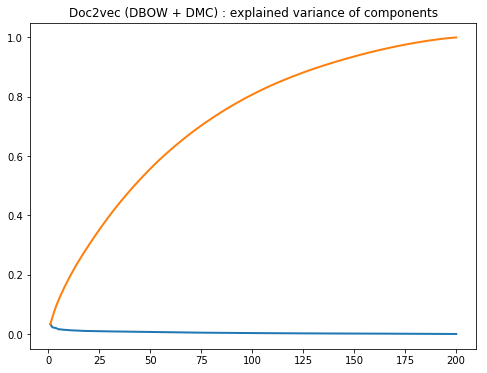

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# use PCA to train Doc2vec -> DBOW (Distributed Bag Of Words) 
scaler = StandardScaler()
d2v_dbow_dmc_std = scaler.fit_transform(train_vecs_dbow_dmc)
d2v_dbow_dmc_std_val = scaler.fit_transform(validation_vecs_dbow_dmc)
d2v_pca = PCA().fit(d2v_dbow_dmc_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, d2v_pca.n_components_+1)
ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (DBOW + DMC) : explained variance of components')

QUESTION: how many gram of DBOW and DMC?  ANSWER: they are both unigram (还没做bigram和trigram的部分）

上图：蓝线表示每个pc component的解释力(explained_variance)，基本持平；橙线表示随着components增加，累计解释度（cumulative explained variance）基本趋于linear。以上说明不同component之间的解释力差别不大 --> not good (理想情况下是希望找到几个重要component能够有显著的解释度）。说明dimension reduction对这个data set的作用不大，一般PCA对numeric features来reduce dimensions表现较好。

<h3> Part 9: Neural Networks with Tfidf vectors using Keras </h3>

<h4> ANN with Tfidf vectorizer

In [41]:
seed = 7
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [42]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0
            
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=batch_generator(x_train_tfidf, train.Sentiment_encode.astype('int'), 32),
                    epochs=5, validation_data=(x_test_tfidf, test.Sentiment_encode.astype('int')),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/5
819/818 [==============================] - 15s 18ms/step - loss: -0.3673 - acc: 0.5231 - val_loss: -1.5356 - val_acc: 0.5934
Epoch 2/5
819/818 [==============================] - 15s 18ms/step - loss: -2.2094 - acc: 0.6478 - val_loss: -2.1682 - val_acc: 0.6417
Epoch 3/5
819/818 [==============================] - 14s 17ms/step - loss: -2.7804 - acc: 0.6998 - val_loss: -2.3072 - val_acc: 0.6580
Epoch 4/5
819/818 [==============================] - 14s 18ms/step - loss: -3.0290 - acc: 0.7239 - val_loss: -2.3646 - val_acc: 0.6709
Epoch 5/5
819/818 [==============================] - 15s 18ms/step - loss: -3.1763 - acc: 0.7382 - val_loss: -2.3827 - val_acc: 0.6794


again 注意命名 -> y_train: train.Sentiment_encode.astype('int') ; y_test: test.Sentiment_encode.astype('int')
x_train: train.reviews; x_test: test.reviews

在5th epoch之后，validation accuracy达到最高值为0.679;显著小于logistic regression的validation accuracy score

In [56]:
# try normalize input to see if yield better results
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit(x_train_tfidf)
x_train_tfidf_norm = norm.transform(x_train_tfidf)
x_test_tfidf_norm = norm.transform(x_test_tfidf)


model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=batch_generator(x_train_tfidf_norm, train.Sentiment_encode.astype('int'), 32),
                    epochs=5, validation_data=(x_test_tfidf_norm, test.Sentiment_encode.astype('int')),
                    steps_per_epoch=x_train_tfidf_norm.shape[0]/32)

Epoch 1/5
819/818 [==============================] - 16s 20ms/step - loss: -0.3441 - acc: 0.5351 - val_loss: -1.5177 - val_acc: 0.5924
Epoch 2/5
819/818 [==============================] - 16s 19ms/step - loss: -2.2079 - acc: 0.6474 - val_loss: -2.1684 - val_acc: 0.6417
Epoch 3/5
819/818 [==============================] - 16s 20ms/step - loss: -2.7811 - acc: 0.6994 - val_loss: -2.3088 - val_acc: 0.6580
Epoch 4/5
819/818 [==============================] - 15s 18ms/step - loss: -3.0308 - acc: 0.7232 - val_loss: -2.3637 - val_acc: 0.6709
Epoch 5/5
819/818 [==============================] - 14s 17ms/step - loss: -3.1758 - acc: 0.7383 - val_loss: -2.3830 - val_acc: 0.6786


normalize之后, validation accuracy反而下降了... 其实tf-idf vectorizer()过程中input就已经normalize了，因此之后无需再normalize一次。

In [58]:
# try add dropout layer to avoid overfitting to the training data

model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim=10000))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.fit_generator(generator=batch_generator(x_train_tfidf, train.Sentiment_encode.astype('int'), 32),
                    epochs=5, validation_data=(x_test_tfidf, test.Sentiment_encode.astype('int')),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)


Epoch 1/5
819/818 [==============================] - 15s 18ms/step - loss: -0.2704 - acc: 0.5131 - val_loss: -1.3914 - val_acc: 0.5807
Epoch 2/5
819/818 [==============================] - 13s 16ms/step - loss: -2.0752 - acc: 0.6367 - val_loss: -2.1224 - val_acc: 0.6378
Epoch 3/5
819/818 [==============================] - 13s 16ms/step - loss: -2.6875 - acc: 0.6915 - val_loss: -2.2939 - val_acc: 0.6556
Epoch 4/5
819/818 [==============================] - 13s 16ms/step - loss: -2.9531 - acc: 0.7148 - val_loss: -2.3672 - val_acc: 0.6659
Epoch 5/5
819/818 [==============================] - 13s 16ms/step - loss: -3.1071 - acc: 0.7302 - val_loss: -2.3922 - val_acc: 0.6763


even adding dropout layer, the neural network model still underperform the logistic regression model

In [60]:
# shuffling data --> another way to avoid overfitting

def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

            
model_s = Sequential()
model_s.add(Dense(64, activation='relu', input_dim=10000))
model_s.add(Dense(1, activation='sigmoid'))
model_s.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, train.Sentiment_encode.astype('int'), 32),
                    epochs=5, validation_data=(x_test_tfidf, test.Sentiment_encode.astype('int')),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)


Epoch 1/5
819/818 [==============================] - 14s 18ms/step - loss: -0.3425 - acc: 0.5174 - val_loss: -1.5247 - val_acc: 0.5812
Epoch 2/5
819/818 [==============================] - 13s 15ms/step - loss: -2.2055 - acc: 0.6459 - val_loss: -2.1672 - val_acc: 0.6418
Epoch 3/5
819/818 [==============================] - 13s 16ms/step - loss: -2.7791 - acc: 0.6991 - val_loss: -2.3133 - val_acc: 0.6620
Epoch 4/5
819/818 [==============================] - 13s 16ms/step - loss: -3.0303 - acc: 0.7227 - val_loss: -2.3687 - val_acc: 0.6699
Epoch 5/5
819/818 [==============================] - 13s 15ms/step - loss: -3.1773 - acc: 0.7378 - val_loss: -2.3832 - val_acc: 0.6791


表现都差不多，仍然underperform logistic regression

<h4> Adjust Learning rate </h4>

In [61]:
# goal: to improve the performance of a neural net can be to adjust the learning rate
import keras

# Learning rate (lr) = 0.005
custom_adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_2 = Sequential()
model_testing_2.add(Dense(64, activation='relu', input_dim=10000))
model_testing_2.add(Dense(1, activation='sigmoid'))
model_testing_2.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, train.Sentiment_encode.astype('int'), 32),
                    epochs=2, validation_data=(x_test_tfidf, test.Sentiment_encode.astype('int')),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2
819/818 [==============================] - 15s 19ms/step - loss: -1.4486 - acc: 0.6049 - val_loss: -2.1923 - val_acc: 0.6515
Epoch 2/2
819/818 [==============================] - 14s 18ms/step - loss: -2.8036 - acc: 0.7104 - val_loss: -2.2674 - val_acc: 0.6751


In [62]:
# try the same for the following learning rate:
# Learning rate (lr) = 0.005
# Learning rate (lr) = 0.01
# Learning rate (lr) = 0.1

Epoch 1/2
819/818 [==============================] - 16s 19ms/step - loss: 0.1760 - acc: 0.5025 - val_loss: -0.4058 - val_acc: 0.5652
Epoch 2/2
819/818 [==============================] - 15s 18ms/step - loss: -1.1442 - acc: 0.5876 - val_loss: -1.5639 - val_acc: 0.5904


try adjust learning rate to (0.0005, 0.005, 0.01, 0.1) -> none of it outperform the default learning rate of 0.001

<h4> Increasing Number of Nodes 

In [66]:
# goal is to improve performance

model_s_2 = Sequential()
model_s_2.add(Dense(128, activation='relu', input_dim=10000))
model_s_2.add(Dense(1, activation='sigmoid'))
model_s_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, train.Sentiment_encode.astype('int'), 32),
                    epochs=2, validation_data=(x_test_tfidf, test.Sentiment_encode.astype('int')),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2
819/818 [==============================] - 25s 31ms/step - loss: -0.6922 - acc: 0.5645 - val_loss: -1.9138 - val_acc: 0.6169
Epoch 2/2
819/818 [==============================] - 26s 31ms/step - loss: -2.5027 - acc: 0.6757 - val_loss: -2.2969 - val_acc: 0.6636


use 128 hidden nodes --> 即便如此，仍然underperform 一般的logistic regression

参考：As a result, in this particular case, neural network models failed to outperform logistic regression. This might be due to the high dimensionality and sparse characteristics of the textual data.  

<h3> Part 10: implement a neural network with Doc2Vec vectors

From previous practice with Neural Network, we found that with high-dimensional sparse data, neural network did not perform well. In this post, I will see if feeding document vectors from Doc2Vec models or word vectors is any different from Tf-idf vectors.

In [57]:
from gensim.models import Doc2Vec

def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

# load pre-trained doc2vec model and prepare
model_ug_dbow = Doc2Vec.load('d2v_model_ug_dbow.doc2vec')   # unigram
model_ug_dmm = Doc2Vec.load('d2v_model_ug_dmm.doc2vec')    # unigram

model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# train combined model 
train_vecs_ugdbow_ugdmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, train.reviews, 200)
validation_vecs_ugdbow_ugdmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, test.reviews, 200)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(train_vecs_ugdbow_ugdmm, train.Sentiment_encode.astype('int'))

print (clf.score(train_vecs_ugdbow_ugdmm, train.Sentiment_encode.astype('int')))  # get training accuracy
print (clf.score(validation_vecs_ugdbow_ugdmm, test.Sentiment_encode.astype('int')))   # get test accuracy

0.7604778990762654
0.754653130287648


注意，跟tutorial (https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-10-neural-network-with-a6441269aa3c) 不太一样，这里我使用的doc2vec model都是unigram model. 

用neural network 去trained doc2vec model得到的training accuracy 和 test accuracy 分别为0.76, 0.754.要比前一章用neural network去train sparse matrix结果要好很多。但accuracy还是低于使用简单方法ti-idf + logistic regression去得到的accuracy结果（0.88）。

In [59]:
# try different data structure
import numpy as np
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# Model example 1: 1 hidden layer with 64 hidden nodes
np.random.seed(seed)  
model_d2v_01 = Sequential()
model_d2v_01.add(Dense(64, activation='relu', input_dim=200))
model_d2v_01.add(Dense(1, activation='sigmoid'))
model_d2v_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_01.fit(train_vecs_ugdbow_ugdmm, train.Sentiment_encode.astype('int'),
                 validation_data=(validation_vecs_ugdbow_ugdmm, test.Sentiment_encode.astype('int')),
                 epochs=10, batch_size=32, verbose=2)


Train on 26198 samples, validate on 11229 samples
Epoch 1/10
 - 2s - loss: -2.7605e-01 - acc: 0.5153 - val_loss: -6.7480e-01 - val_acc: 0.5436
Epoch 2/10
 - 1s - loss: -7.3707e-01 - acc: 0.5527 - val_loss: -8.6068e-01 - val_acc: 0.5506
Epoch 3/10
 - 2s - loss: -9.2326e-01 - acc: 0.5691 - val_loss: -9.4030e-01 - val_acc: 0.5809
Epoch 4/10
 - 1s - loss: -1.0622e+00 - acc: 0.5827 - val_loss: -1.0206e+00 - val_acc: 0.5729
Epoch 5/10
 - 2s - loss: -1.1871e+00 - acc: 0.5901 - val_loss: -1.0516e+00 - val_acc: 0.5913
Epoch 6/10
 - 1s - loss: -1.2879e+00 - acc: 0.5979 - val_loss: -1.1026e+00 - val_acc: 0.5800
Epoch 7/10
 - 1s - loss: -1.3961e+00 - acc: 0.6036 - val_loss: -1.1326e+00 - val_acc: 0.5800
Epoch 8/10
 - 1s - loss: -1.4999e+00 - acc: 0.6118 - val_loss: -1.1618e+00 - val_acc: 0.5684
Epoch 9/10
 - 1s - loss: -1.6046e+00 - acc: 0.6149 - val_loss: -1.1446e+00 - val_acc: 0.5970
Epoch 10/10
 - 2s - loss: -1.6993e+00 - acc: 0.6226 - val_loss: -1.1910e+00 - val_acc: 0.5874


In [61]:
# Model example 2: 2 hidden layers with 64 hidden nodes each
np.random.seed(seed)
model_d2v_02 = Sequential()
model_d2v_02.add(Dense(64, activation='relu', input_dim=200))
model_d2v_02.add(Dense(64, activation='relu'))  # difference to model 1
model_d2v_02.add(Dense(1, activation='sigmoid'))

model_d2v_02.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_d2v_02.fit(train_vecs_ugdbow_ugdmm, train.Sentiment_encode.astype('int'),
                 validation_data=(validation_vecs_ugdbow_ugdmm, test.Sentiment_encode.astype('int')),
                 epochs=10, batch_size=32, verbose=2)

Train on 26198 samples, validate on 11229 samples
Epoch 1/10
 - 2s - loss: -4.7789e-01 - acc: 0.5356 - val_loss: -9.2754e-01 - val_acc: 0.5635
Epoch 2/10
 - 2s - loss: -1.0303e+00 - acc: 0.5862 - val_loss: -1.1085e+00 - val_acc: 0.6050
Epoch 3/10
 - 2s - loss: -1.2358e+00 - acc: 0.6047 - val_loss: -1.1763e+00 - val_acc: 0.5767
Epoch 4/10
 - 2s - loss: -1.4189e+00 - acc: 0.6167 - val_loss: -1.2573e+00 - val_acc: 0.6139
Epoch 5/10
 - 2s - loss: -1.5961e+00 - acc: 0.6280 - val_loss: -1.2786e+00 - val_acc: 0.5982
Epoch 6/10
 - 2s - loss: -1.7660e+00 - acc: 0.6346 - val_loss: -1.2987e+00 - val_acc: 0.6203
Epoch 7/10
 - 2s - loss: -1.9087e+00 - acc: 0.6450 - val_loss: -1.3136e+00 - val_acc: 0.6214
Epoch 8/10
 - 2s - loss: -2.0434e+00 - acc: 0.6551 - val_loss: -1.3217e+00 - val_acc: 0.6166
Epoch 9/10
 - 2s - loss: -2.1433e+00 - acc: 0.6606 - val_loss: -1.3240e+00 - val_acc: 0.6279
Epoch 10/10
 - 2s - loss: -2.2528e+00 - acc: 0.6681 - val_loss: -1.2916e+00 - val_acc: 0.6294


model2相比model1增加了hidden layers nodes，accuracy也从0.5+ 上升到0.6+ <br>
可以尝试不同的neural network settings: (去比较不同的accuracy结果）
- a range of hidden layers (from 1 to 3) 
- a range of hidden nodes for each hidden layer (64, 128, 256, 512)


In [64]:
# use "check point" function of keras can be more efficient
# used “checkpoint” and “earlystop”. You can set the “checkpoint” function with options, 
# and with the below parameter setting, “checkpoint” will save the best performing model up until the point of running

from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath="d2v_09_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]
np.random.seed(seed)

model_d2v_09_es = Sequential()
model_d2v_09_es.add(Dense(256, activation='relu', input_dim=200))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dense(1, activation='sigmoid'))
model_d2v_09_es.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_09_es.fit(train_vecs_ugdbow_ugdmm, train.Sentiment_encode.astype('int'),
                    validation_data=(validation_vecs_ugdbow_ugdmm, test.Sentiment_encode.astype('int')), 
                    epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)

Train on 26198 samples, validate on 11229 samples
Epoch 1/100
 - 5s - loss: -6.8111e-01 - acc: 0.5596 - val_loss: -1.0225e+00 - val_acc: 0.5676

Epoch 00001: val_acc improved from -inf to 0.56764, saving model to d2v_09_best_weights.01-0.5676.hdf5
Epoch 2/100
 - 4s - loss: -1.1008e+00 - acc: 0.5951 - val_loss: -1.0847e+00 - val_acc: 0.5993

Epoch 00002: val_acc improved from 0.56764 to 0.59934, saving model to d2v_09_best_weights.02-0.5993.hdf5
Epoch 3/100
 - 4s - loss: -1.3470e+00 - acc: 0.6168 - val_loss: -1.2156e+00 - val_acc: 0.5974

Epoch 00003: val_acc did not improve from 0.59934
Epoch 4/100
 - 4s - loss: -1.5927e+00 - acc: 0.6351 - val_loss: -1.2968e+00 - val_acc: 0.6057

Epoch 00004: val_acc improved from 0.59934 to 0.60566, saving model to d2v_09_best_weights.04-0.6057.hdf5
Epoch 5/100
 - 4s - loss: -1.8233e+00 - acc: 0.6543 - val_loss: -1.3134e+00 - val_acc: 0.6427

Epoch 00005: val_acc improved from 0.60566 to 0.64271, saving model to d2v_09_best_weights.05-0.6427.hdf5
Epoc

the best performance of the model is 0.66 (accuracy), and not getting any better

In [66]:
# if evaluate the model, it will show the results from last best performance
model_d2v_09_es.evaluate(x=validation_vecs_ugdbow_ugdmm, y=test.Sentiment_encode.astype('int'))

11229/11229 [==============================] - 1s 58us/step


[-1.233111369980338, 0.6606999732781543]

In [68]:
from keras.models import load_model
loaded_model = load_model('d2v_09_best_weights.17-0.6619.hdf5')
loaded_model.evaluate(x=validation_vecs_ugdbow_ugdmm, y=test.Sentiment_encode.astype('int'))

11229/11229 [==============================] - 1s 70us/step


[-1.3528976420471235, 0.6618576898861679]

结果相比tf-idf vectorizer()+logistic regression还是差很多

<h4> Implement a neural network with Word2Vec vectors

将doc2vec转化成word2vec，再用neural network去train word2vec

In [74]:
# Approach1: averaged word vectors
model_ug_dmm = Doc2Vec.load('d2v_model_ug_dmm.doc2vec')
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

def get_w2v_ugdbowdmm(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += np.append(model_ug_dbow[word],model_ug_dmm[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

train_vecs_w2v_dbowdmm = np.concatenate([get_w2v_ugdbowdmm(z, 200) for z in train.reviews])
validation_vecs_w2v_dbowdmm = np.concatenate([get_w2v_ugdbowdmm(z, 200) for z in test.reviews])

clf = LogisticRegression()
clf.fit(train_vecs_w2v_dbowdmm, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_w2v_dbowdmm, test.Sentiment_encode.astype('int'))

0.7261554902484638

基于averaged word vectors的unigram model得到的accuracy rate(0.72) 要比doc2vec好

In [76]:
# scale input vector --> 减少processing time
from sklearn.preprocessing import scale

train_vecs_w2v_dbowdmm_s = scale(train_vecs_w2v_dbowdmm)
validation_vecs_w2v_dbowdmm_s = scale(validation_vecs_w2v_dbowdmm)

clf = LogisticRegression()
clf.fit(train_vecs_w2v_dbowdmm_s, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_w2v_dbowdmm_s, test.Sentiment_encode.astype('int'))

0.7514471457832398

processing time 减少，同时accuracy也提高了(0.75)

In [78]:
# Approach2: summation word vector
# def get_w2v_ugdbowdmm_sum: ... 定义function (可参考之前的average function)

def get_w2v_ugdbowdmm_sum(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += np.append(model_ug_dbow[word],model_ug_dmm[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    return vec

train_vecs_w2v_dbowdmm_sum = np.concatenate([get_w2v_ugdbowdmm_sum(z, 200) for z in train.reviews])
validation_vecs_w2v_dbowdmm_sum = np.concatenate([get_w2v_ugdbowdmm_sum(z, 200) for z in test.reviews])

clf = LogisticRegression()
clf.fit(train_vecs_w2v_dbowdmm_sum, train.Sentiment_encode.astype('int'))
clf.score(validation_vecs_w2v_dbowdmm_sum, test.Sentiment_encode.astype('int'))

0.7345266720099741

用sum word vector相比averaged word vector, accuracy减少 （0.73）

In [83]:
# approach3: Word vectors extracted from Doc2Vec models with TFIDF weighting (Average/Sum) => training时间长
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(min_df=2)
tvec.fit_transform(train.reviews)
tfidf = dict(zip(tvec.get_feature_names(), tvec.idf_))

def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

# TODO： figure out what does it mean here
w2v_tfidf = {}
for w in model_ug_dbow.wv.vocab.keys():
    if w in tvec.get_feature_names():
        w2v_tfidf[w] = np.append(model_ug_dbow[w],model_ug_dmm[w]) * tfidf[w]

# average
train_vecs_w2v_tfidf_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'mean') for z in train.reviews]))
validation_vecs_w2v_tfidf_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'mean') for z in test.reviews]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_tfidf_mean, train.Sentiment_encode.astype('int'))
print (clf.score(validation_vecs_w2v_tfidf_mean, test.Sentiment_encode.astype('int')))

# sum
train_vecs_w2v_tfidf_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'sum') for z in train.reviews]))
validation_vecs_w2v_tfidf_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'sum') for z in test.reviews]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_tfidf_sum, train.Sentiment_encode.astype('int'))
print (clf.score(validation_vecs_w2v_tfidf_sum, test.Sentiment_encode.astype('int')))

0.7210793481164841
0.6998842283373408


average word vectors的accuracy高于sum word vectors

In [86]:
# TODO: Word vectors extracted from Doc2Vec models with custom weighting (Average/Sum)
# TODO: Word vectors extracted from pre-trained GloVe (Average/Sum)
# TODO: Word vectors extracted from pre-trained Google News Word2Vec (Average/Sum)

# TODO: Separately trained Word2Vec (Average/Sum)

w2v_pos_hmean_01 = {}
for w in model_ug_cbow.wv.vocab.keys():
    if w in pos_hmean.keys():
        w2v_pos_hmean_01[w] = np.append(model_ug_cbow[w],model_ug_sg[w]) * pos_hmean[w]
        
train_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in train.reviews]))
validation_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in test.reviews]))

clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_mean_01, train.Sentiment_encode.astype('int'))
print (clf.score(validation_vecs_w2v_poshmean_mean_01, test.Sentiment_encode.astype('int')))

train_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in train.reviews]))
validation_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in test.reviews]))

clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_sum_01, train.Sentiment_encode.astype('int'))
print (clf.score(validation_vecs_w2v_poshmean_sum_01, test.Sentiment_encode.astype('int')))

# TODO: Separately trained Word2Vec with custom weighting (Average/Sum)



NameError: name 'model_ug_cbow' is not defined

In [84]:
# TODO: Neural Network with Word2Vec

# TODO:
train_w2v_final = train_vecs_w2v_poshmean_mean_01
validation_w2v_final = validation_vecs_w2v_poshmean_mean_01

from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="w2v_01_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]
np.random.seed(seed)

model_w2v_01 = Sequential()
model_w2v_01.add(Dense(256, activation='relu', input_dim=200))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(1, activation='sigmoid'))
model_w2v_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_w2v_01.fit(train_w2v_final, y_train, validation_data=(validation_w2v_final, y_validation), 
                 epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)

NameError: name 'train_vecs_w2v_poshmean_mean_01' is not defined

<h2>Deeping Learning

<h3>Representation: Sequence Creation

In [18]:
# tokenization
from keras.preprocessing.text import Tokenizer
## Tokenize the sentences

max_features = 276    # max length of reviews
tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(train_X)+list(test_X))
tokenizer.fit_on_texts(list(X_train)+list(X_test))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
# Pad Sequence
from keras.preprocessing.sequence import pad_sequences

maxlen = 276
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)    

<h3> Embedding Enrichment

will be using GLoVE Word2Vec embeddings to explain the enrichment.

In [27]:
# load glove index

def load_glove_index():
#     EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    EMBEDDING_FILE = './input/glove.42B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]    # 选最常出现的300 words
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

glove_embedding_index = load_glove_index()

In [38]:
# list(glove_embedding_index.items())[:3]

In [ ]:
# create glove (add polarity and lowercase as well)

def create_glove(word_index,embeddings_index):
    emb_mean,emb_std = -0.005838499,0.48782197
    all_embs = np.stack(embeddings_index.values())
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size+4))
    
    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        word_sent = TextBlob(word).sentiment
        # Extra information we are passing to our embeddings
        extra_embed = [word_sent.polarity,word_sent.subjectivity]
        if embedding_vector is not None: 
            embedding_matrix[i] =  np.append(embedding_vector,extra_embed)
        else:
            if word.islower():
                embedding_vector = embeddings_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = np.append(embedding_vector,extra_embed)
                else:
                    embedding_matrix[i,300:] = extra_embed
                    count_found-=1
            else:
                embedding_matrix[i,300:] = extra_embed
                count_found-=1
    print("Got embedding for ",count_found," words.")
    return embedding_matrix